In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as A
import pandas as pd
from sklearn.manifold import TSNE
import sklearn.manifold 
from matplotlib import pyplot as plt
import re
import codecs
from numpy  import array
from scipy import stats
# from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import os
from tensorboardX import SummaryWriter

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

# PREPROCESSING

In [2]:
corpus_filename = '../data/extracted_emoji_sequences.txt' 

In [3]:
corpus = open(corpus_filename).read().splitlines()

In [4]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [5]:
def onlyEmojiSequences(tokens):
    threshold_emojis = [x for x in tokens if len(x) > 1]
    return threshold_emojis

In [6]:
tokenized_corpus = tokenize_corpus(corpus)
emojiSequences = onlyEmojiSequences(tokenized_corpus)

In [7]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

# this is just the very basic translation both ways plus the length of vocabulary

In [8]:
window_size = 8
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

# sole purpose of this is to have pairs! of target and context word
# super simple once you have figured out the code!

In [9]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

# this is a one hot encoded something

# TRAINING

In [10]:
testWriter = SummaryWriter()

In [13]:
def stop_training():
    change = priorLoss / avgLoss.item()
    if (priorLoss == 0 or change > 1.05):
        return False
    else:
        return True

In [ ]:
dtype = torch.float 
dimensionSize = 7
num_epochs = 80
learning_rate = 0.001
priorLoss = 0
avgLoss = 0

firstLayer = torch.randn(dimensionSize, vocabulary_size, requires_grad=True).float()
secondLayer = torch.randn(vocabulary_size, dimensionSize, requires_grad=True).float()

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:

        # one hot encoded tensor
        x = get_input_layer(data).float()
        # target word 
        y_true = torch.from_numpy(np.array([target])).long()

        # Hidden Layer: gradient magic happening ...
        z1 = torch.matmul(firstLayer, x)
        z2 = torch.matmul(secondLayer, z1)

        # introducing non-linearity
        softmax = A.LogSoftmax(dim=0)
        soft_max_output = softmax(z2)

        # neg_log_likelihood
        loss = F.nll_loss(soft_max_output.view(1,-1), y_true)
        loss_val += loss  # this might be to please the  framework, and adding stuff to the gradient calculator
        
        # propagating it back
        loss.backward()
        
        # updating the weights of both layers
        firstLayer.data -= learning_rate * firstLayer.grad.data
        secondLayer.data -= learning_rate * secondLayer.grad.data

        # set the gradients to zero for next iteration
        firstLayer.grad.data.zero_()
        secondLayer.grad.data.zero_()
    avgLoss = loss_val/len(idx_pairs)
    print(f'Loss at epo {epo}: {avgLoss}')
    testWriter.add_scalar('lossvalue', avgLoss, epo)
    if stop_training():
        break
    else:
        priorLoss = avgLoss.item()

#export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
testWriter.close

Loss at epo 0: 5.937771320343018
Loss at epo 1: 4.649865627288818
Loss at epo 2: 4.389577865600586


In [24]:
if not os.path.exists("SOFTMAX_trained"):
    os.makedirs("SOFTMAX_trained")

In [25]:
torch.save(secondLayer, os.path.join("SOFTMAX_trained", "test#2.w2v"))

# EVALUATING TRAINED MODEL

In [14]:
loadedLayer = torch.load(os.path.join("SOFTMAX_trained", "5percent#1.w2v"))

In [30]:
# extracts the 508 Annotator Results as the Gold-Standard
corpus_filename = '../data/EmoSim508.json'
corpus = open(corpus_filename).read()
annotator_similarity_score_508 = list(array(re.findall('(?<=_Annotator_Agreement": )(.*?)(?=\})', corpus)))

# extract Wijeratne's Cosine_Similarities of the model which was trained on Google_Sense_Labels
google_sense_labels_score_508 = list(array(re.findall('(?<=Google_Sense_Label": )(.*?)(?=\,)', corpus)))

# glyph_pairs_1016
unicode_pairs_1016 = re.findall('(?<=unicodelong": "\\\)(.*?)(?=")', corpus)    
glyph_pairs_1016 = [codecs.decode(unicode_pairs_1016[x].replace(str('\\\\'),str('\\')).replace('_',''), 'unicode_escape') for x in range(len(unicode_pairs_1016))]

# computation of Cosine Similarity
goldstandard = []
selftrained = []
google_sense_labels = []
emoji_ticks_xaxis = []
for x in range(len(annotator_similarity_score_508)):
    cosineSimilarity = None
    
    emoji1 = glyph_pairs_1016.pop(0)
    emoji2 = glyph_pairs_1016.pop(0)
    
    try:
        cosineSimilarity = cosine_similarity(loadedLayer.detach().cpu().numpy()[word2idx[emoji1]].reshape(-1,300), loadedLayer.detach().cpu().numpy()[word2idx[emoji2]].reshape(-1,300))[0][0]
    except:
        print('the cosine similarity between ' + emoji1 + ' and ' + emoji2 + ' could not be computed.')
    
    if(cosineSimilarity is not None):
        goldstandard.append(annotator_similarity_score_508.pop(0))
        selftrained.append(cosineSimilarity)
        google_sense_labels.append(float(google_sense_labels_score_508.pop(0)))
        one_tick = emoji1 + emoji2
        emoji_ticks_xaxis.append(one_tick)
        

# skalierter GoldStandard
min_max_scaler = preprocessing.MinMaxScaler()
scaled_goldstandard = min_max_scaler.fit_transform(np.asarray(goldstandard).reshape(-1, 1))

print()

# computation of SPEARRANK CORRELATION COEFFICIENT
meinSPEARMAN = stats.spearmanr(goldstandard, selftrained)
seinSPEARMAN = stats.spearmanr(goldstandard, google_sense_labels)
print('mein Spearman: {}'.format(meinSPEARMAN.correlation))
print('sein Spearman: {}'.format(seinSPEARMAN.correlation))


# computation of MAE
meinMAE = mean_absolute_error(scaled_goldstandard, min_max_scaler.fit_transform(np.asarray(selftrained).reshape(-1, 1)))
seinMAE = mean_absolute_error(scaled_goldstandard, google_sense_labels)
print('mein MAE ist {}'.format(meinMAE))
print('sein MAE ist {}'.format(seinMAE))


# computation of MSE
meinMSE = mean_squared_error(scaled_goldstandard, min_max_scaler.fit_transform(np.asarray(selftrained).reshape(-1, 1)))
seinMSE = mean_squared_error(scaled_goldstandard, google_sense_labels)
print('mein MSE ist {}'.format(meinMSE))
print('sein MSE ist {}'.format(seinMSE))


the cosine similarity between 🇬🇧 and 🇺🇸 could not be computed.
the cosine similarity between 🏅 and 🇺🇸 could not be computed.
the cosine similarity between 🇺🇸 and ❤ could not be computed.
the cosine similarity between 🇺🇸 and 💥 could not be computed.
the cosine similarity between 🎤 and 🇳🇬 could not be computed.
the cosine similarity between 🇳🇬 and 📲 could not be computed.
the cosine similarity between 👇 and 🇳🇬 could not be computed.
the cosine similarity between 🎧 and 🇳🇬 could not be computed.
the cosine similarity between 🇳🇬 and 🎶 could not be computed.

mein Spearman: 0.26081293646823833
sein Spearman: 0.7592834163731204
mein MAE ist 0.2823634684085846
sein MAE ist 0.23933867735470943
mein MSE ist 0.1086303488426247
sein MSE ist 0.07912399799599198


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U4 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


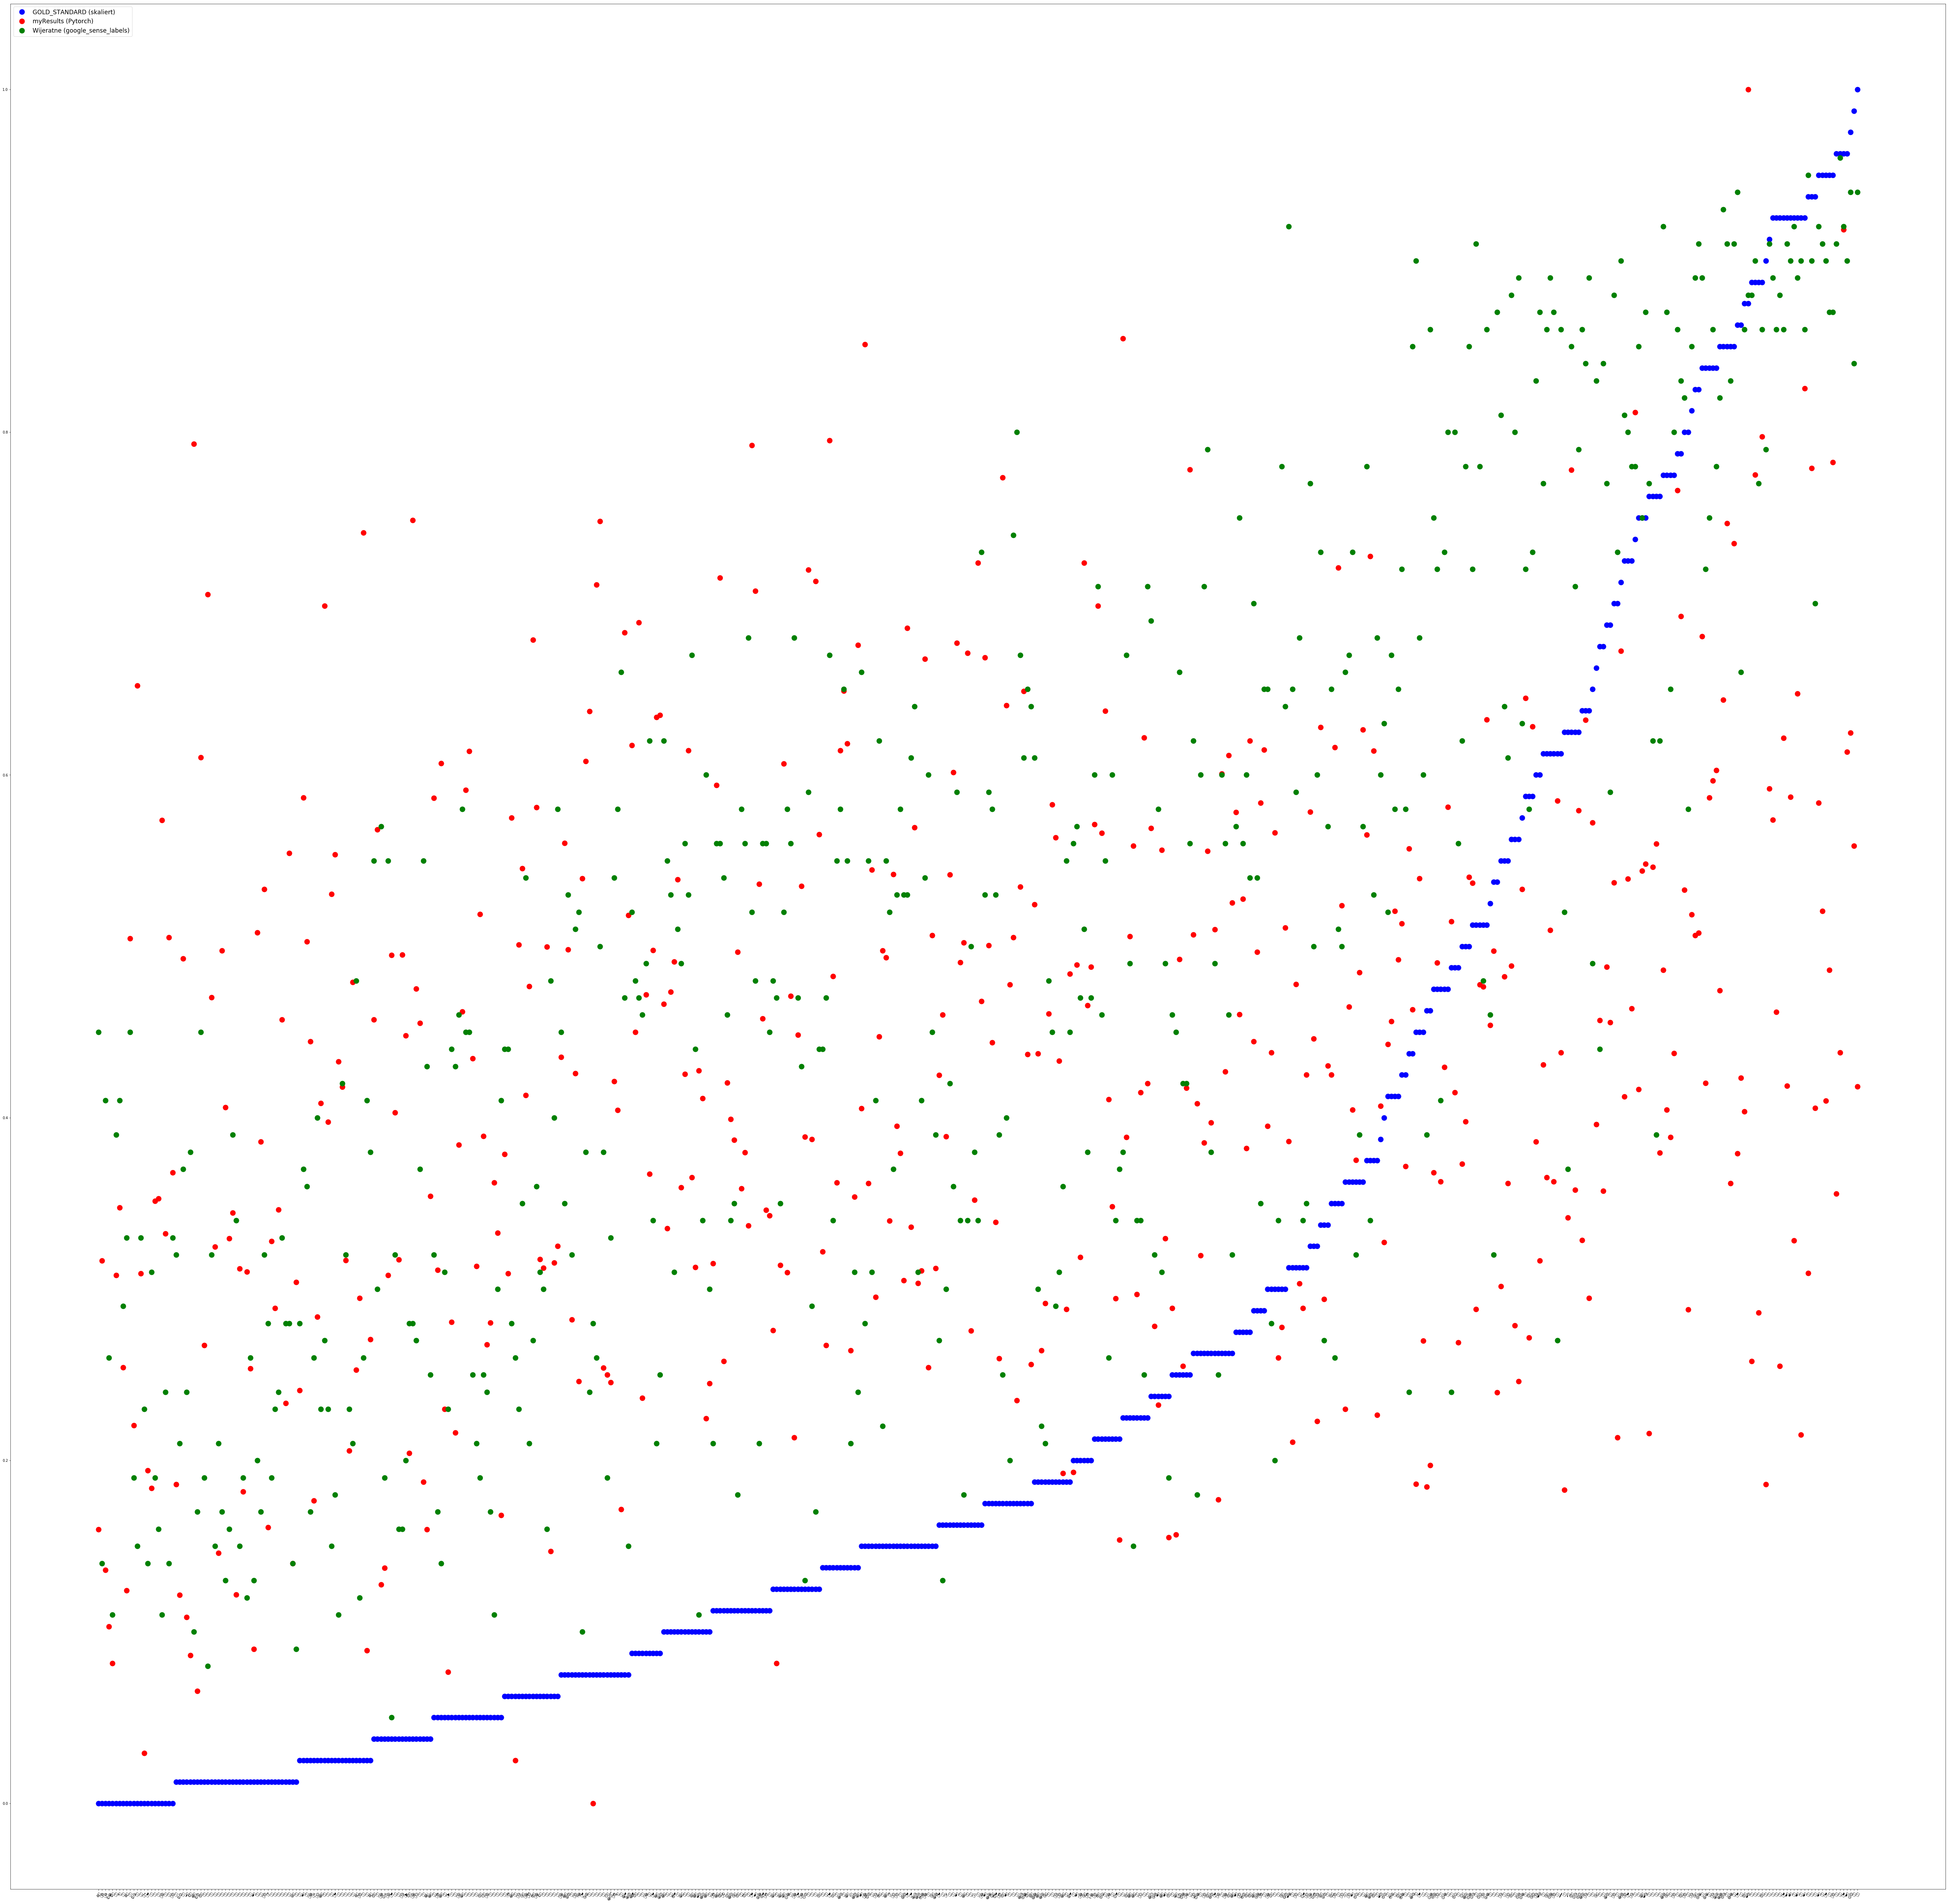

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# evenly sampled time at 200ms intervals

# red dashes, blue squares and green triangles
plt.figure(figsize=(100,100))

plt.xticks(range(0,len(emoji_ticks_xaxis)), emoji_ticks_xaxis[::-1])
plt.xticks(rotation=60)


plt.plot(range(0,len(emoji_ticks_xaxis)), scaled_goldstandard[::-1], 'bo', label = "GOLD_STANDARD (skaliert)", markersize=15)
plt.plot(range(0,len(emoji_ticks_xaxis)), min_max_scaler.fit_transform(np.asarray(selftrained).reshape(-1, 1))[::-1], 'ro', label = "myResults (Pytorch)", markersize=15)
plt.plot(range(0,len(emoji_ticks_xaxis)), google_sense_labels[::-1], 'go', label = "Wijeratne (google_sense_labels)", markersize=15)



plt.savefig('test.png', bbox_inches='tight')

# try differnt fonts
from matplotlib.font_manager import FontProperties

leg = plt.legend(loc='upper left', fontsize = 'xx-large')


plt.savefig('test.png', bbox_inches='tight')



